## Introduction

If you're interested in learning about object detection using KerasCV, I highly suggest
taking a look at the guide created by lukewood. This resource, available at
[Object Detection With KerasCV](https://keras.io/guides/keras_cv/object_detection_keras_cv/#object-detection-introduction),
provides a comprehensive overview of the fundamental concepts and techniques
required for building object detection models with KerasCV.

In [54]:
#!pip install --upgrade git+https://github.com/keras-team/keras-cv -q
#!pip install -q --upgrade keras-cv
#!pip install -q --upgrade tensorflow
#!pip install -q --upgrade keras --use-deprecated=legacy-resolver

In [2]:
#!wget https://universe.roboflow.com/ds/GG1XJhlbDK?key=FFxqUqVjub -O indoor_object_detection.zip

In [3]:
#!unzip "indoor_object_detection.zip" -d "dataset/"

## Setup

In [1]:
import os
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow import keras

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization
import keras

2024-02-01 17:39:45.298904: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-01 17:39:45.486851: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 17:39:45.486891: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 17:39:45.516198: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-01 17:39:45.572319: I tensorflow/core/platform/cpu_feature_guar

Using TensorFlow backend


In [36]:
#physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [37]:
#tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-02-01 17:39:56.462273: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-01 17:39:56.580039: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-01 17:39:56.580086: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Load Data

## Hyperparameters

In [3]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 2
LEARNING_RATE = 0.001
EPOCH = 10
GLOBAL_CLIPNORM = 10.0

A dictionary is created to map each class name to a unique numerical identifier. This
mapping is used to encode and decode the class labels during training and inference in
object detection tasks.

In [5]:
class_ids = [
    "TV", "bed", "chair", "clock", "console", "consoleeeeee", "door", "fan", "light", "sofa", "switchboard", "table"
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

# Path to images and annotations
path_images = "../dataset/train/"
path_annot = "../dataset/train/"

# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".xml")
    ]
)

# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpg")
    ]
)

In [6]:

def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids


image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)

  0%|          | 0/4660 [00:00<?, ?it/s]

In [42]:
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

Splitting data in training and validation data

In [43]:
# Determine the number of validation samples
num_val = int(len(xml_files) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

In [44]:
print(len(image_paths))
print(num_val)
print(train_data.__len__())

4660
932
tf.Tensor(3728, shape=(), dtype=int64)


In [45]:

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}


In [46]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        )
    ]
)

## Creating Training Dataset

In [47]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

## Creating Validation Dataset

In [48]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

## Visualization

2024-01-31 17:49:46.413201: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-01-31 17:49:47.107115: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9830528 bytes after encountering the first element of size 9830528 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


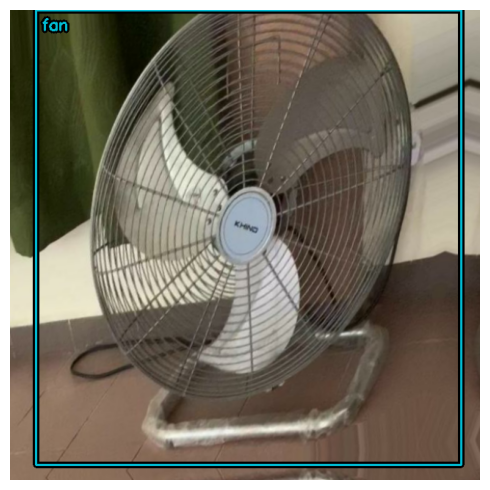

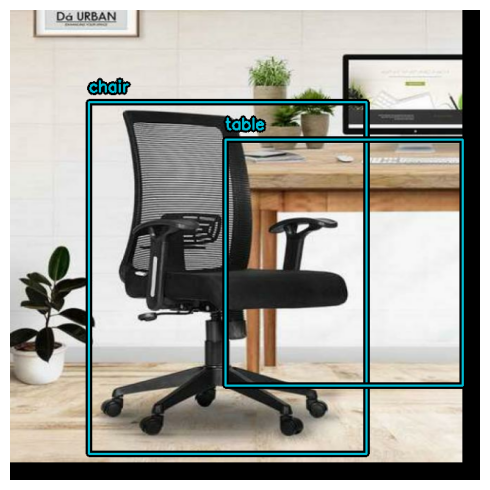

In [50]:

def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=1,
        cols=1,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

We need to extract the inputs from the preprocessing dictionary and get them ready to be
fed into the model.

In [56]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

TypeError: in user code:


    TypeError: outer_factory.<locals>.inner_factory.<locals>.tf__dict_to_tuple() takes 1 positional argument but 2 were given


## Creating Model

You can read more about YOLOV8 and its architecture in this
[RoboFlow Blog](https://blog.roboflow.com/whats-new-in-yolov8/)

In [57]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco",  # We will use yolov8 small backbone with coco weights
    trainable = False
)

/home/andrea/.local/lib/python3.10/site-packages/keras_cv/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/andrea/.local/lib/python3.10/site-packages/keras_cv/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


Next, let's build a YOLOV8 model using the `YOLOV8Detector`, which accepts a feature
extractor as the `backbone` argument, a `num_classes` argument that specifies the number
of object classes to detect based on the size of the `class_mapping` list, a
`bounding_box_format` argument that informs the model of the format of the bbox in the
dataset, and a finally, the feature pyramid network (FPN) depth is specified by the
`fpn_depth` argument.

It is simple to build a YOLOV8 using any of the aforementioned backbones thanks to
KerasCV.

In [58]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=3
)

In [59]:
yolo.summary()

Model: "yolov8_detector"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 model (Functional)          {'P3': (None, None, None,    5089760   ['input_2[0][0]']             
                             128),                                                                
                              'P4': (None, None, None,                                            
                             256),                                                                
                              'P5': (None, None, None,                                            
                             512)}                                                  

In [ ]:
#for layer in yolo.layers:
#    if "yolo_v8_head" in layer.name:
#        print(layer.name + " - " + str(layer.trainable))
#        layer.trainable = True
#    else:
#        layer.trainable = False

## Compile the Model

Loss used for YOLOV8


1. Classification Loss: This loss function calculates the discrepancy between anticipated
class probabilities and actual class probabilities. In this instance,
`binary_crossentropy`, a prominent solution for binary classification issues, is
Utilized. We Utilized binary crossentropy since each thing that is identified is either
classed as belonging to or not belonging to a certain object class (such as a person, a
car, etc.).

2. Box Loss: `box_loss` is the loss function used to measure the difference between the
predicted bounding boxes and the ground truth. In this case, the Complete IoU (CIoU)
metric is used, which not only measures the overlap between predicted and ground truth
bounding boxes but also considers the difference in aspect ratio, center distance, and
box size. Together, these loss functions help optimize the model for object detection by
minimizing the difference between the predicted and ground truth class probabilities and
bounding boxes.


In [ ]:
#tf.keras.backend.clear_session()

In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)
yolo.summary()

## COCO Metric Callback

We will be using `BoxCOCOMetrics` from KerasCV to evaluate the model and calculate the
Map(Mean Average Precision) score, Recall and Precision. We also save our model when the
mAP score improves.

In [ ]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=False)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs


In [ ]:
yolo.load_weights("model-01282024-121425.h5")
#yolo = keras_cv.models.load("model.h5")

In [ ]:
#yolo.save("model_3ep.h5")

## Train the Model

In [ ]:
yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCH,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds, "model.h5")],
)

## Visualize Predictions

In [ ]:

def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(201)))
    print(images.shape)
    print(y_true)
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    print(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        true_color = (0,0,255),
        pred_color = (0,255,0),
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy")

In [ ]:
print(val_ds.cardinality())

(1, 640, 640, 3)


2024-01-28 23:31:53.492731: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-28 23:31:56.043163: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-28 23:31:56.732204: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 14s 14s/step
{'boxes': <tf.RaggedTensor [[[55.538963, 275.30692, 366.1436, 503.42355],
  [291.89398, 358.99002, 611.8519, 606.4009],
  [295.80298, 394.45398, 564.8023, 594.4265]]]>, 'confidence': <tf.RaggedTensor [[0.5486799, 0.2899013, 0.2179333]]>, 'classes': <tf.RaggedTensor [[3.0, 3.0, 3.0]]>, 'num_detections': array([3], dtype=int32)}


IndexError: index 1 is out of bounds for axis 0 with size 1

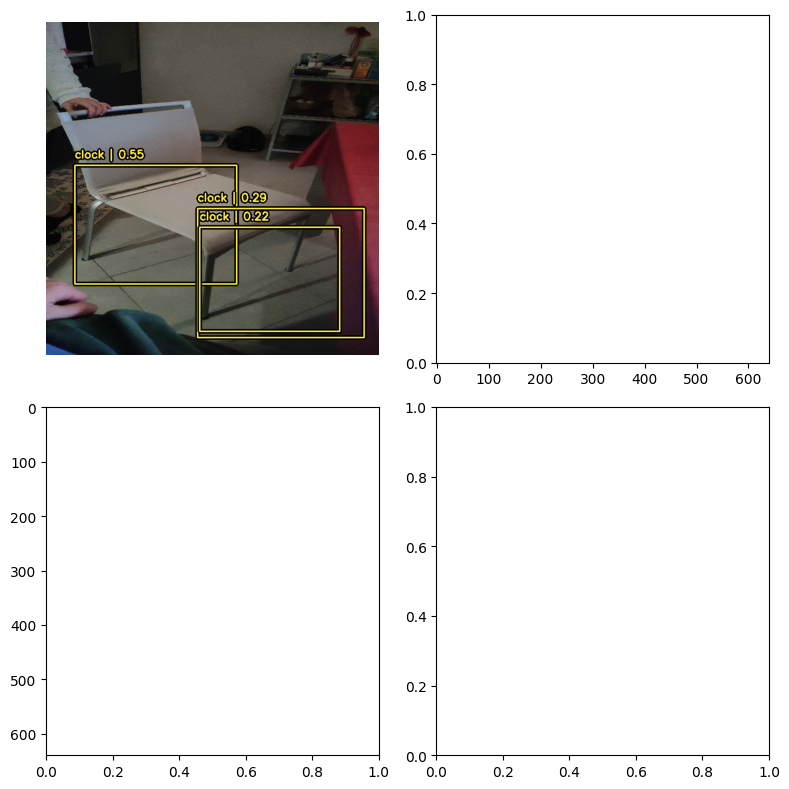

In [26]:
def visualize_generic(model, image_name, bounding_box_format):
    #images = load_image(os.path.join(path_images, image_name))
    image = tf.io.read_file(image_name)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [640,640])
    images = tf.cast(image, tf.float32)
    images = tf.expand_dims(images, axis=0)
    print(images.shape)

    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    print(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        #y_true={},
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


visualize_generic(yolo, image_name="testimage_2.jpg", bounding_box_format="xyxy")
#img_0120_jpg.rf.36da0f1b2f59ec13cb70e1b82defd9a0.jpg